# 多辆车的路径规划 VRP：

1. 任务目标：使得每辆车的行驶里程数更接近
2. 约束条件：经过中国33个城市，一共4辆车，每辆车最大行驶10000公里

数据预处理：
1. 设置 num_vehicles，代表一共多少量车
2. 设置 depot，代表所有车的起始出发点一样，都是从节点depot开始
3. 添加距离约束，即每辆车的最大行驶距离
需要注意：
4. 在VRP问题中，路径上给点赋的index和点实际的index不一样，需要使用IndexToNode方法进行转换才能得到实际的index

## 地图数据获取

In [1]:
import pandas as pd
import numpy as np
import requests
import json

In [2]:
# 高德key
KEY = '6bf16587d81d190a4fb2290cc000208e'

# 获取城市经纬度
def get_location(city, key=KEY):
    location_url = 'https://restapi.amap.com/v3/geocode/geo?address={}&output=JSON&key={}'.format(city, key)
    location = json.loads(requests.get(location_url).text)['geocodes'][0]['location']
    return [float(x) for x in location.split(',')]


# 获取两城市行车距离
def get_distance(location1, location2, key=KEY):
    distance_url = 'https://restapi.amap.com/v3/distance?origins={},{}&destination={},{}&output=JSON&key={}'.format
    distance_url = distance_url(location1[0], location1[1], location2[0], location2[1], key)
    result = json.loads(requests.get(distance_url).text)['results'][0]
    return {'distance': int(result['distance']), 'duration': int(result['duration'])}

In [3]:
# 城市名称
CITIES = ['北京', '天津', '哈尔滨', '长春', '沈阳', '石家庄', '呼和浩特', '太原', '上海', '杭州','福州', 
          '广州', '海口', '合肥', '郑州', '南京', '济南', '兰州', '银川', '西宁', '西安','拉萨', '乌鲁木齐', 
          '成都', '重庆', '南宁', '贵阳', '昆明', '武汉', '长沙', '南昌', '香港','澳门']

In [4]:
# 城市经纬度数据
df_dict = {'city': [], 'lng': [], 'lat': []}

for city in CITIES:
    location = get_location(city)
    df_dict['city'].append(city)
    df_dict['lng'].append(location[0])
    df_dict['lat'].append(location[1])
    
df_location = pd.DataFrame(df_dict)
df_location.to_csv('./cities loaction.csv')
df_location.head()

,city,lng,lat
0,北京,116.407526,39.904030
1,天津,117.200983,39.084158
2,哈尔滨,126.534967,45.803775
3,长春,125.323544,43.817071
4,沈阳,123.431474,41.805698


In [5]:
# 城市间距离，包括路程和时间
df_distance = pd.DataFrame(np.zeros(shape=(len(CITIES), len(CITIES))), index=CITIES, columns=CITIES)
df_duration = pd.DataFrame(np.zeros(shape=(len(CITIES), len(CITIES))), index=CITIES, columns=CITIES)

for i in range(len(CITIES)-1):
    for j in range(i+1, len(CITIES)):
        city1, city2 = CITIES[i], CITIES[j]
        location1 = df_location.query('city == "{}"'.format(city1))[['lng', 'lat']].values[0]
        location2 = df_location.query('city == "{}"'.format(city2))[['lng', 'lat']].values[0]
        result = get_distance(location1, location2)
        
        df_distance.loc[city1, city2] = result['distance']
        df_distance.loc[city2, city1] = result['distance']
        
        df_duration.loc[city1, city2] = result['duration']
        df_duration.loc[city2, city1] = result['duration']

df_distance.to_csv('./cities distance.csv')
df_duration.to_csv('./cities duration.csv')

In [6]:
df_distance.head()

,北京,天津,哈尔滨,长春,沈阳,石家庄,呼和浩特,太原,上海,杭州,...,成都,重庆,南宁,贵阳,昆明,武汉,长沙,南昌,香港,澳门
北京,0.0,136557.0,1242377.0,973173.0,685685.0,292216.0,479321.0,489526.0,1221577.0,1272280.0,...,1855964.0,1768202.0,2345408.0,2082754.0,2558770.0,1168392.0,1505755.0,1402372.0,2249826.0,2264448.0
天津,136557.0,0.0,1226619.0,957415.0,669927.0,315435.0,605831.0,512745.0,1093822.0,1142710.0,...,1879183.0,1791421.0,2354550.0,2091896.0,2581989.0,1177534.0,1514897.0,1335591.0,2191707.0,2273590.0
哈尔滨,1242377.0,1226619.0,0.0,271343.0,560122.0,1507423.0,1686535.0,1704733.0,2288235.0,2337123.0,...,3071171.0,2983409.0,3560615.0,3297961.0,3773977.0,2383599.0,2720962.0,2541012.0,3397128.0,3479655.0
长春,973173.0,957415.0,271343.0,0.0,291354.0,1238655.0,1438950.0,1435965.0,2019467.0,2068355.0,...,2802403.0,2714641.0,3291847.0,3029193.0,3505209.0,2114831.0,2452194.0,2272244.0,3128360.0,3210887.0
沈阳,685685.0,669927.0,560122.0,291354.0,0.0,952381.0,1160833.0,1149691.0,1733193.0,1782081.0,...,2516129.0,2428367.0,3005573.0,2742919.0,3218935.0,1828557.0,2165920.0,1985970.0,2842086.0,2924613.0


In [7]:
df_duration.head()

,北京,天津,哈尔滨,长春,沈阳,石家庄,呼和浩特,太原,上海,杭州,...,成都,重庆,南宁,贵阳,昆明,武汉,长沙,南昌,香港,澳门
北京,0.0,7380.0,54840.0,41220.0,29700.0,14820.0,21900.0,23400.0,50880.0,52740.0,...,83580.0,81540.0,96900.0,91440.0,115200.0,48840.0,63120.0,60660.0,95040.0,96360.0
天津,7380.0,0.0,54600.0,40980.0,29520.0,16140.0,29700.0,24720.0,45540.0,47760.0,...,84720.0,82800.0,96600.0,91200.0,116460.0,48540.0,62820.0,58320.0,93960.0,96120.0
哈尔滨,54840.0,54600.0,0.0,14220.0,24420.0,65220.0,74280.0,74640.0,100140.0,100980.0,...,134100.0,130380.0,148620.0,142320.0,169440.0,98940.0,112080.0,109020.0,144960.0,145860.0
长春,41220.0,40980.0,14220.0,0.0,12780.0,53100.0,61980.0,63120.0,87660.0,89040.0,...,121920.0,119460.0,136920.0,131400.0,158580.0,88080.0,101340.0,97440.0,133020.0,133560.0
沈阳,29700.0,29520.0,24420.0,12780.0,0.0,43320.0,54780.0,53700.0,79260.0,81060.0,...,113040.0,111300.0,127200.0,121320.0,149580.0,79920.0,92400.0,89220.0,124380.0,124620.0


## 规划问题求解

In [8]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [94]:
# 生成数据模型
def create_data_model(num_vehicles, depot ,strategy='distance'):
    data = {}
    
    if strategy == 'distance':
        data['distance_matrix'] = df_distance.values.tolist()
    elif strategy == 'duration':
        data['distance_matrix'] = df_duration.values.tolist()
        
    data['num_vehicles'] = num_vehicles
    data['depot'] = depot
    return data

# 输出结果
def print_solution(manager, routing, solution):
    city_seq = []
    total_distance = 0
    
    for i in range(4):
        route_list = []
        index = routing.Start(i)
        plan_output = '车辆的路径:\n'
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} ->'.format(CITIES[manager.IndexToNode(index)])
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
            plan_output += CITIES[manager.IndexToNode(index)]
            route_list.append(CITIES[manager.IndexToNode(index)])
            
    #     print(plan_output)
        print('{}公里'.format(route_distance/1000))
        total_distance += route_distance/1000
        city_seq.append(route_list)
    print('总{}公里'.format(int(total_distance)))
    return city_seq

In [95]:
def main():
    # 初始化数据
    data = create_data_model(4, 0, 'distance')

    # 创建路线管理，tsp_size（城市数量）, num_vehicles（车的数量）, depot（原点）
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # 创建 Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # 计算两点之间的距离
    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # 添加距离约束
    max_length = 10000*1000
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        max_length,  # 车辆最大行驶距离
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    
    # 尽量减少车辆之间的最大距离
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # 求解路径规划
    solution = routing.SolveWithParameters(search_parameters)
    
    # 输出结果
    if solution:
        seq = print_solution(manager, routing, solution)

    return seq

## 规划可视化

In [96]:
import matplotlib.image as imgplt
import matplotlib.pyplot as plt

In [97]:
# paths 构造
def get_paths(location_seq_list):
    colors = ['0x008000','0x800080','0xFFFF00','0x0000FF','0x808080','0xffa500','0xFF0000','0xFFFFFF']
    path = '|'.join(['3,{},0.8,,:{}'.format(colors[idx],i) for idx, i in enumerate([';'.join([str(x[0])+','+str(x[1]) for x in y]) for y in location_seq_list])])
    return path

# location_seq_list -> (batch, sep, location)
def show_optimal_path(location_seq_list, key=KEY):
    # api 请求
    base_url = 'https://restapi.amap.com/v3/staticmap?zoom=3&scale=2&location=106.265866,38.146062&size=1024*576&paths={}&key={}'.format
    paths = get_paths(location_seq_list)

    # url 构造
    request_url = base_url(paths, key)
    
    # 图片下载
    res = requests.get(request_url)
    jpg_path = './temp_map.jpg'
    with open(jpg_path, 'wb') as f:
        f.write(res.content)
    
    # 画图
    plt.figure(figsize=(32, 18))
    x = imgplt.imread(jpg_path)
    plt.imshow(x)
    plt.show()

## 问题求解

7147.027公里
6696.391公里
7291.499公里
7176.491公里
总28311公里


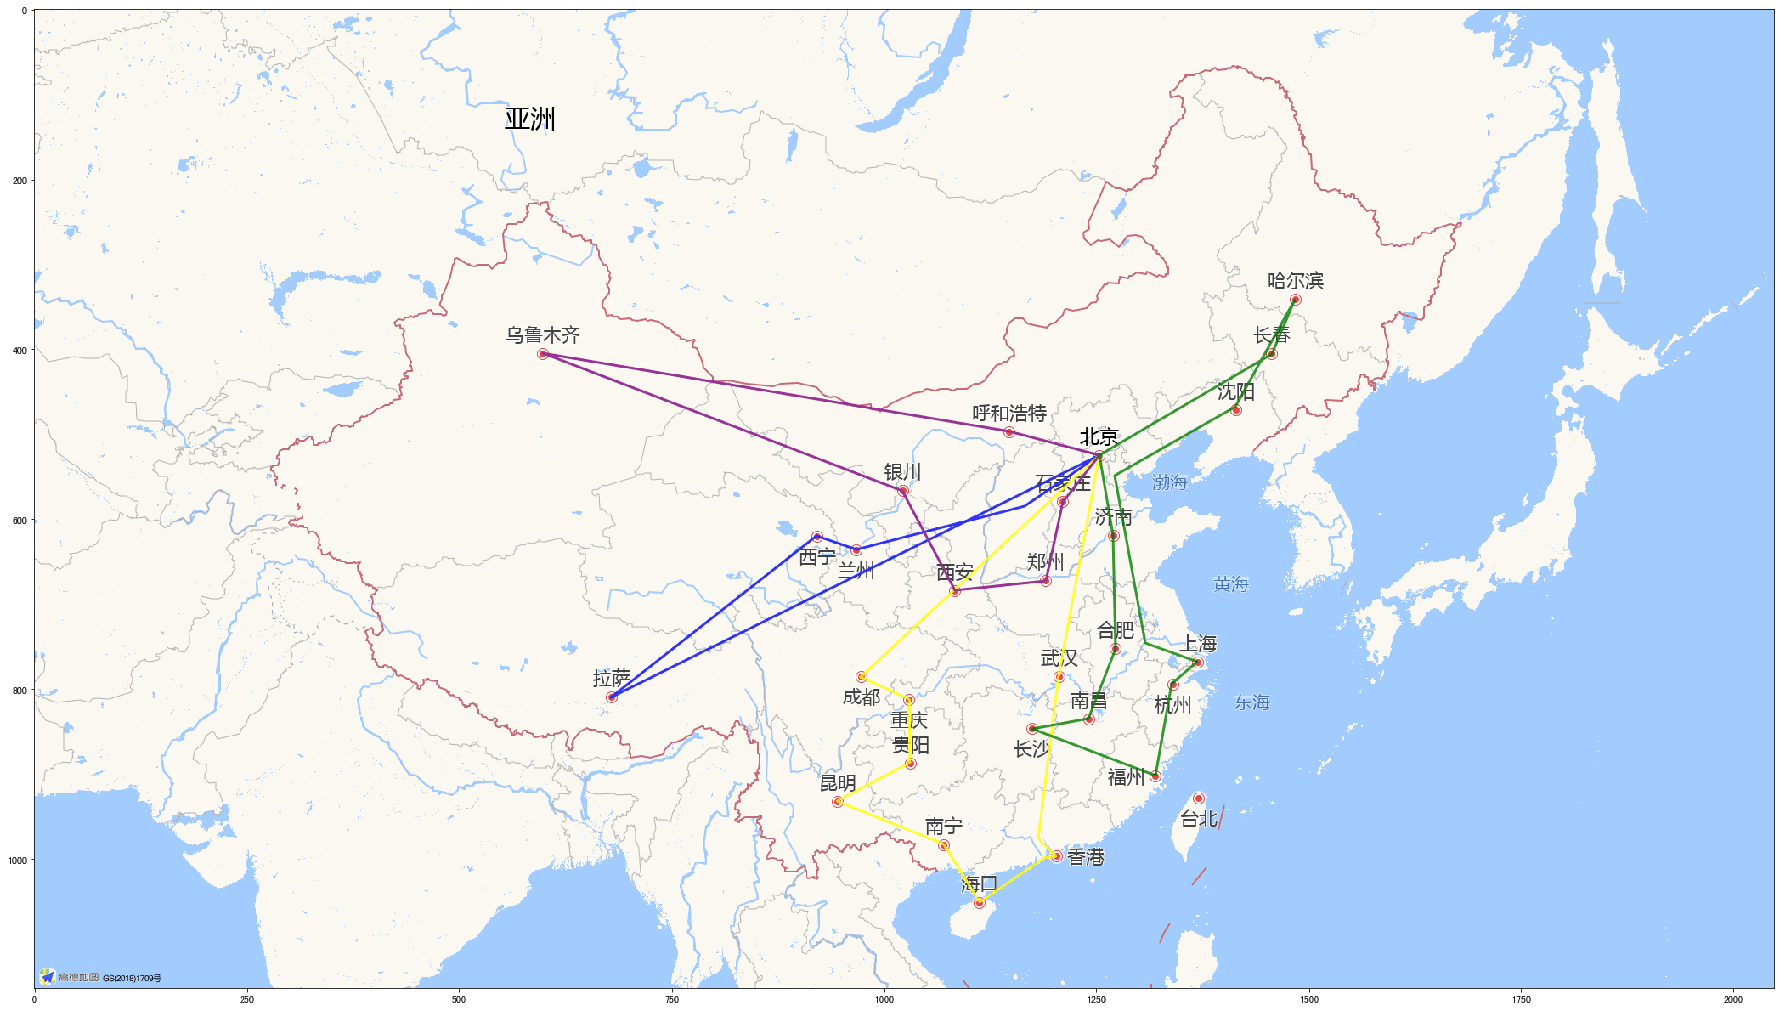

In [98]:
seq = main()
location_seq = []
for i in seq:
    temp = [df_location[df_location['city']==x][['lng', 'lat']].values[0].tolist() for x in i]
    temp = temp + [temp[0]]
    location_seq.append(temp)
show_optimal_path(location_seq)